In [3]:
import torch
a = torch.tensor([1])
torch.save(a,"trained_models/a.pth")

# Scene Setup


In [1]:
import numpy as np
import genesis as gs # type: ignore

def gs_simul_setup(entity_name):
    ########################## init ##########################
    gs.init(seed=0, precision='32', logging_level='info')

    dt = 5e-4
    scene = gs.Scene(
        sim_options=gs.options.SimOptions(
            substeps=10,
            gravity=(0, 0, 0),
        ),
        viewer_options= gs.options.ViewerOptions(
            camera_pos=(1.5, 0, 0.8),
            camera_lookat=(0.5, 1, 0.3),
            camera_fov=40,
        ),
        mpm_options=gs.options.MPMOptions(
            dt=dt,
            lower_bound=(-1.0, -1.0, -0.2),
            upper_bound=( 1.0,  1.0,  1.0),
        ),
        fem_options=gs.options.FEMOptions(
            dt=dt,
        ),
        vis_options=gs.options.VisOptions(
            show_world_frame=True,
        ),
        show_viewer=False,
        # renderer=gs.renderers.RayTracer(  # type: ignore
        #     env_surface=gs.surfaces.Emission(
        #         emissive_texture=gs.textures.ImageTexture(
        #             image_path="textures/indoor_bright.png",
        #         ),
        #     ),
        # ),
        renderer=gs.renderers.Rasterizer()
    )

    ########################## entities ##########################
    # scene.add_entity(morph=gs.morphs.Plane())

    E, nu = 3.e4, 0.45
    rho = 1000.


    torus_fem_0 = scene.add_entity(
        morph=gs.morphs.Mesh(
            file=f'assets/{entity_name}.obj',#,f'assets/material_0',f'assets/material.mtl'],
            pos=(0.5, 1, 0.3),
            scale=0.2,
            ),
        # material=gs.materials.FEM.Muscle(
        #     E=E,
        #     nu=nu,
        #     rho=rho,
        #     model='stable-neohooken',
        # ),
        surface=gs.surfaces.Rough(
            diffuse_texture=gs.textures.ImageTexture(
                image_path="assets/textures/all_low_lunghs_BaseColor.lungh_part01.jpeg",
            )
        )

    )

    # torus_fem_1 = scene.add_entity(
    #     morph=gs.morphs.Mesh(
    #         file='assets/Torus.obj',
    #         pos=(0.5, 0.4, 0.3),
    #         scale=0.2,
    #         ),
    #     material=gs.materials.FEM.Muscle(
    #         E=E,
    #         nu=nu,
    #         rho=rho,
    #         model='stable-neohooken',
    #     ),
    # )


    cam = scene.add_camera(
        res    = (640, 480),
        pos    = (4, 0.4, 0.3), # (3,,) per torus is enough
        # lookat = (0.5, 1, 1),
        fov    = 40,
        far    = 500,
        GUI    = False,
    )

    ########################## build ##########################
    scene.build()

    return scene, cam

scene, cam = gs_simul_setup("lungs")
# entity = scene.entities[0]
# 

[I 11/18/25 11:54:26.196 918828] [shell.py:_shell_pop_print@25] Graphical python shell detected, using wrapped sys.stdout


[Genesis] [11:54:28] [INFO] ╭───────────────────────────────────────────────╮
[Genesis] [11:54:28] [INFO] │┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈ Genesis ┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈│
[Genesis] [11:54:28] [INFO] ╰───────────────────────────────────────────────╯
[Genesis] [11:54:28] [INFO] Running on [NVIDIA RTX A4000] with backend gs.cuda. Device memory: 15.58 GB.
[Genesis] [11:54:28] [INFO] 🚀 Genesis initialized. 🔖 version: 0.3.6, 🎨 theme: dark, 🌱 seed: 0, 🐛 debug: False, 📏 precision: 32, 🏎️ performance: False, 💬 verbose: INFO
[Genesis] [11:54:31] [INFO] Scene <0ebe5a9> created.
[Genesis] [11:54:31] [INFO] Adding <gs.RigidEntity>. idx: 0, uid: <476a173>, morph: <gs.morphs.Mesh(file='/home/matteo/genesis_tests/assets/lungs.obj')>, material: <gs.materials.Rigid>.
[Genesis] [11:54:32] [INFO] Convex hull is not accurate enough for collision detection (1.144). Falling back to more expensive convex decomposition (see FileMorph options).
[Genesis] [11:54:32] [INFO] Building scene <0ebe5a9>...
[Genesis] [11:54:44] [INFO

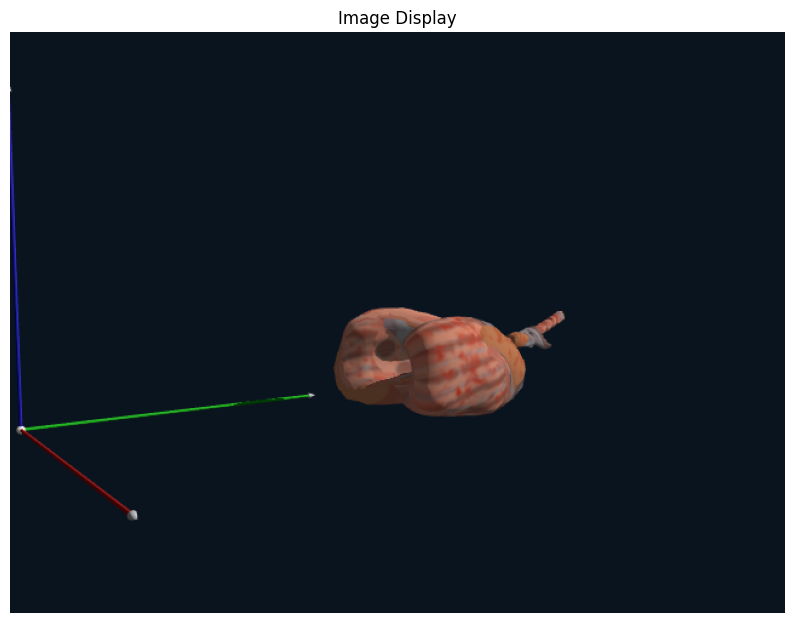

In [19]:
from data import show_image
cam.set_pose(pos=(2.5,-0.5,0.5), lookat=(0.5, 1, 0.3))
show_image(cam.render()[0])

In [6]:
torus_fem_0 = scene.entities[0]


tensor([[0.8463, 0.4957, 0.0512]], device='cuda:0')
[Genesis] [15:33:13] [WARNING] Manally setting element positions. This is not recommended and could break gradient flow.
[Genesis] [15:33:13] [INFO] Running at 0.16 FPS.


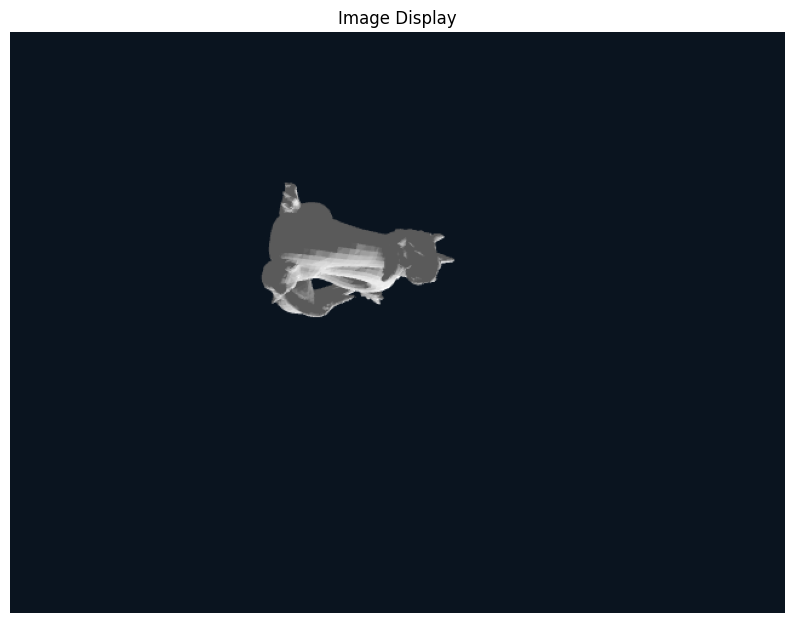

In [ ]:
import torch
from utils.rotation import rotate_entity
from data import show_image

rotation = torch.tensor([[0.,0.,0.]])
scene.reset()
center=torch.tensor([0.5, 0.1, 0.3])
rotate_entity(torus_fem_0,rotation,center)
scene.step()
cam.set_pose(pos=(0,-1,90),lookat=(1,1,1))
show_image(cam.render()[0])



# Dataset

In [16]:
import torch
import numpy as np
from utils.rotation import rotate_entity


!mkdir -p dataset
n = 5
for f1 in range(n):
    for f2 in range(n):
        for f3 in range(n):
            angle = torch.tensor([torch.pi * f1 / n, torch.pi * f2 / n, torch.pi * f3 / n])
            scene.reset()
            rotate_entity(torus_fem_0, angle[0], angle[1], angle[2], center=None)
            scene.step()
            # save image and rotation matrix
            img = np.array(cam.render()[0])
            # R = rotation_matrix_xyz(angle[0], angle[1], angle[2])
            R = torch.tensor([angle[0], angle[1], angle[2]])
            # save img and R to disk
            img_filename = f"dataset/image_f1_{f1}_f2_{f2}_f3_{f3}_n_{n}.npy"
            R_filename = f"dataset/rotation_f1_{f1}_f2_{f2}_f3_{f3}_n_{n}.th"
            np.save(img_filename, img)
            torch.save(R, R_filename)

[Genesis] [14:47:23] [WARNING] Manally setting element positions. This is not recommended and could break gradient flow.
[Genesis] [14:47:23] [INFO] Running at 0.08 FPS.


AttributeError: 'NoneType' object has no attribute 'render'

# Train

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModel

class DeformNet(nn.Module):
    def __init__(self):
        super(DeformNet, self).__init__()
        self.set_feature_extractor()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 9)  # Output 3x3 rotation matrix
    
    def set_feature_extractor(self):
        self.processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
        self.dinov2 = AutoModel.from_pretrained('facebook/dinov2-base')
        for param in self.dinov2.parameters():
            param.requires_grad = False  # Freeze the feature extractor
        
    def forward(self, x):
        inputs = self.processor(images=x, return_tensors="pt")
        outputs = self.dinov2(**inputs)
        x = outputs.last_hidden_state  # (batch_size, seq_len, feature_dim)
        x = torch.mean(x, dim=1)  # Global average pooling
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 3, 3)  # Reshape to 3x3 matrix
        return x

In [7]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

class ImageRotationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the dataset folder containing images and .npy rotation matrices.
            transform (callable, optional): Optional transform to be applied to images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for fname in os.listdir(self.root_dir):
            if fname.lower().endswith((".npy", ".jpg", ".jpeg")):
                base = os.path.splitext(fname)[0]
                img_path = os.path.join(self.root_dir, fname)
                rot_path = os.path.join(self.root_dir, f"{base.replace("image", "rotation")}.th")
                if os.path.exists(rot_path):
                    samples.append((img_path, rot_path))
                
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, rot_path = self.samples[idx]
        # Load image
        image = np.load(img_path)
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        
        # Load rotation matrix (3x3)
        rotation_matrix = torch.load(rot_path)

        return image, rotation_matrix

def show_image(image_array):
    """
    Display an image from a numpy array.
    
    Parameters:
    image_array (np.ndarray): Image array with shape (height, width, channels)
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(image_array)
    plt.axis('off')  # Hide axes
    plt.title('Image Display')
    plt.show()

def create_dataloader(
    root_dir, batch_size=32, shuffle=True, num_workers=0, img_size=224):
    """
    Create a PyTorch DataLoader for (image, rotation_matrix) pairs.
    """
    transform = transforms.Compose([
        # transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        # transforms.Normalize(),
    ])

    dataset = ImageRotationDataset(root_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=shuffle, num_workers=num_workers)
    return dataloader

dataloader = create_dataloader('dataset', batch_size=8)

for images, rotations in dataloader:
    print("Batch of images shape:", images.shape)
    print("Batch of rotation matrices shape:", rotations.shape)
    show_image(images[0].permute(1,2,0))
    print(rotations[0])
    break   




RuntimeError: Expected a 'cuda' device type for generator but found 'cpu'

In [ ]:
def train():
    from tqdm.notebook import tqdm
    
    dataloader = create_dataloader('dataset', batch_size=8)
    deformnet = DeformNet()
    optimizer = torch.optim.Adam(deformnet.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    for epoch in range(1):  # number of epochs
        for i, (images, rotation_matrices) in tqdm(enumerate(dataloader)):
            optimizer.zero_grad()
            outputs = deformnet(images.to("cuda"))
            loss = criterion(outputs.to("cuda"), rotation_matrices.to("cuda"))
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")
    
    return deformnet


trained_model = train()

In [ ]:
torch.save(trained_model, "trained.pt")

# Test

## Test scene setup (add second torus to evaluate overlapping)

In [1]:
import numpy as np
import genesis as gs

def gs_simul_setup():
    ########################## init ##########################
    gs.init(seed=0, precision='32', logging_level='info')

    dt = 5e-4
    scene = gs.Scene(
        sim_options=gs.options.SimOptions(
            substeps=10,
            gravity=(0, 0, 0),
        ),
        viewer_options= gs.options.ViewerOptions(
            camera_pos=(1.5, 0, 0.8),
            camera_lookat=(0.0, 0.0, 0.0),
            camera_fov=40,
        ),
        mpm_options=gs.options.MPMOptions(
            dt=dt,
            lower_bound=(-1.0, -1.0, -0.2),
            upper_bound=( 1.0,  1.0,  1.0),
        ),
        fem_options=gs.options.FEMOptions(
            dt=dt,
        ),
        vis_options=gs.options.VisOptions(
            show_world_frame=False,
        ),
        show_viewer=True,
    )

    ########################## entities ##########################
    scene.add_entity(morph=gs.morphs.Plane())

    E, nu = 3.e4, 0.45
    rho = 1000.


    torus_fem_0 = scene.add_entity(
        morph=gs.morphs.Mesh(
            file='source/Torus.obj',
            pos=(0.5, 0.4, 0.3),
            scale=0.2,
            ),
        material=gs.materials.FEM.Muscle(
            E=E,
            nu=nu,
            rho=rho,
            model='stable-neohooken',
        ),
    )

    torus_fem_1 = scene.add_entity(
        morph=gs.morphs.Mesh(
            file='source/Torus.obj',
            pos=(0.5, 0.4, 0.3),
            scale=0.2,
            ),
        material=gs.materials.FEM.Muscle(
            E=E,
            nu=nu,
            rho=rho,
            model='stable-neohooken',
        ),
    )


    cam = scene.add_camera(
        res    = (640, 480),
        pos    = (3., 0.4, 0.3),
        lookat = (0.5, 0.4, 0.3),
        fov    = 30,
        GUI    = False,
    )


    ########################## build ##########################
    scene.build()

    return scene, cam

scene, cam = gs_simul_setup()
torus_fem_0 = scene.entities[1]
torus_fem_1 = scene.entities[2]


[I 11/14/25 10:56:02.127 20040] [shell.py:_shell_pop_print@25] Graphical python shell detected, using wrapped sys.stdout


[Genesis] [10:56:03] [INFO] ╭───────────────────────────────────────────────╮
[Genesis] [10:56:03] [INFO] │┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈ Genesis ┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈│
[Genesis] [10:56:03] [INFO] ╰───────────────────────────────────────────────╯
[Genesis] [10:56:04] [INFO] Running on [NVIDIA GeForce GTX 1650 Ti] with backend gs.cuda. Device memory: 3.63 GB.
[Genesis] [10:56:04] [INFO] 🚀 Genesis initialized. 🔖 version: 0.3.6, 🎨 theme: dark, 🌱 seed: 0, 🐛 debug: False, 📏 precision: 32, 🏎️ performance: False, 💬 verbose: INFO
[Genesis] [10:56:06] [INFO] Scene <b425f10> created.
[Genesis] [10:56:06] [INFO] Adding <gs.RigidEntity>. idx: 0, uid: <c71be91>, morph: <gs.morphs.Plane>, material: <gs.materials.Rigid>.
[Genesis] [10:56:06] [INFO] Adding <gs.FEMEntity>. idx: 1, uid: <381e4c1>, morph: <gs.morphs.Mesh(file='/home/flaccagora/Desktop/test/genesis/source/Torus.obj')>, material: <gs.FEM.Muscle>.
[Genesis] [10:56:06] [INFO] Adding <gs.FEMEntity>. idx: 2, uid: <e2a7b69>, morph: <gs.morphs.Mesh(file='/ho

## Plot

In [ ]:
import torch
trained_model = DeformNet()
trained_model = torch.load("trained.pt", weights_only=False)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [48]:
from data import ImageRotationDataset
import numpy as np

def get_random_image():
    dataset = ImageRotationDataset("dataset")

    image, rotation = dataset.samples[np.random.randint(len(dataset.samples))]
    image = np.load(image)
    rotation = torch.load(rotation)

    return torch.tensor(image), rotation

def get_predicted_rotation(image, trained_model):
    image_pt = torch.tensor([image])
    predicted_rotation = trained_model(image_pt)
    return predicted_rotation.squeeze(0)

# image, rotation = get_random_image()
# pred_rotation = get_predicted_rotation(image,trained_model)


In [58]:
image, rotation = get_random_image()
pred_rotation = get_predicted_rotation(image,trained_model)

scene.reset()
rotate_entity(torus_fem_0,rotation)
rotate_entity(torus_fem_1,pred_rotation.to("cuda"))
scene.step()

criterion = nn.MSELoss()
print("loss: ", criterion(rotation.to("cuda"),pred_rotation.to("cuda")))


[Genesis] [11:03:52] [WARNING] Manally setting element positions. This is not recommended and could break gradient flow.
[Genesis] [11:03:52] [WARNING] Manally setting element positions. This is not recommended and could break gradient flow.
[Genesis] [11:03:52] [INFO] Running at 0.11 FPS.
loss:  tensor(0.6179, device='cuda:0', grad_fn=<MseLossBackward0>)


In [51]:
from torchvision.transforms.functional import to_pil_image

In [53]:
image.shape

torch.Size([480, 640, 3])

In [ ]:
from transformers import pipeline
from transformers.image_utils import load_image

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
image = load_image(url)

feature_extractor = pipeline(
    model="facebook/dinov3-vitB16-pretrain-lvd1689m",
    task="image-feature-extraction", 
)
image, rotation = get_random_image()

features = feature_extractor(to_pil_image(image.permute(2,0,1)))
import torch 
torch.tensor(features).shape


Device set to use cuda:0


torch.Size([1, 201, 768])

In [32]:
import torch
from transformers import AutoImageProcessor, AutoModel
from transformers.image_utils import load_image

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
image = load_image(url)

pretrained_model_name = "facebook/dinov3-vitB16-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
model = AutoModel.from_pretrained(
    pretrained_model_name, 
    device_map="auto",
)

inputs = processor(images=image, return_tensors="pt").to(model.device)
with torch.inference_mode():
    outputs = model(**inputs)

pooled_output = outputs.pooler_output
print("Pooled output shape:", pooled_output.shape)


Pooled output shape: torch.Size([1, 768])
